Here is the list of "low input single cell approximation" (LISCA)
experiments.

* Experiments loaded Information 
  * <a href="#Small-Input-Experiments">Small Input Experiment Table</a>
  * <a href="#Bulk-ENCODE-RNA-Seq-Evaluation-Data">Bulk ENCODE RNA-Seq Evaluation Data</a>
* Corelation Scores
  * <a href="#Report-scores-for-two-small-input-replicates">Scores one small input experiment</a>
  * <a href="#Correlation-Scores-for-bulk-experiment">Correlation scores for an RNA Evaluation experiment</a>
* Plots comparing Correlations
  * <a href="#Naive-Pearson-Comparison">Naive Pearson</a>
  * <a href="#Naive-Spearman-Comparison">Naive Spearman</a>
  * <a href="#Rafa-Pearson-Comparison">Rafa Pearson</a>
  * <a href="#Rafa-Spearman-Comparison">Rafa Spearman</a>
  * <a href="#Rafa-MAD-Comparison">MAD of Log Ratios</a>
  * <a href="#Rafa-SD-Comparison">SD of Log Ratios</a>
* Plots comparing just low input
  * <a href="#Only-Small-Input-Correlations">Correlations</a>
  * <a href="#Small-Input-MAD/SD">MAD and SD of Log Ratios</a>

In [1]:
import pandas
import numpy
import scipy.stats
import collections

In [2]:
from curation_common import *

In [3]:
%matplotlib inline
from matplotlib import pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
server = ENCODED('www.encodeproject.org')
server.load_netrc()

# Functions used later

## Data Loader

In [5]:
def load_fpkms(experiment_files):
    """Load FPKMs out of RSEM results into a pandas dataframe
    
    Columns will be library accession identifiers.
    """
    results = []
    libraries = []
    for i, row in enumerate(experiment_files):
        experiment = str(row['experiment'])
        library = str(row['library'])[-12:-1]
        url = str(row['file_href'])
        fpkms = pandas.read_csv(url, sep='\t', index_col=0, usecols=[0,6])
        libraries.append(library)
        results.append(fpkms)
    df = pandas.concat(results, axis=1)
    df.columns = libraries
    return df

## Correlation computations

In [6]:
def replicate_scores(table, rep1_name, rep2_name):
    """Compute correlations, MAD, and SD replicate comparison scores
    """
    rep1 = table[rep1_name]
    rep2 = table[rep2_name]
    
    eitherzero = (rep1 == 0) | (rep2 == 0)
    replz1 = numpy.log2(rep1[eitherzero != True])
    replz2 = numpy.log2(rep2[eitherzero != True])
    
    M = replz1 - replz2
    A = (replz1 + replz2) / 2.0

    Acutoff = 0

    scores = pandas.Series({
        'total rows': len(table),
        'passed filter': len(replz1[A > Acutoff]),
            
        'Naïve Pearson': scipy.stats.pearsonr(rep1, rep2)[0],
        'Naïve Spearman': scipy.stats.spearmanr(rep1, rep2)[0],
            
        'Rafa Pearson': scipy.stats.pearsonr(replz1[A > Acutoff], replz2[A > Acutoff])[0],
        'Rafa Spearman': scipy.stats.spearmanr(replz1[A > Acutoff], replz2[A > Acutoff])[0],
        'MAD': numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3),
        'SD': numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3)
    },
    index = ['total rows', 'passed filter', 
             'Naïve Pearson', 'Naïve Spearman', 
             'Rafa Pearson', 'Rafa Spearman',
             'MAD', 'SD']
    )
    return scores

In [46]:
def compute_all_vs_all_scores(fpkms):
    """Compute all the scores of note for a FPKM table.
    """
    all_scores = collections.OrderedDict()
    shape = (len(fpkms.columns),len(fpkms.columns))
    for rep1 in fpkms.columns:
        for rep2 in fpkms.columns:
            scores = replicate_scores(fpkms, rep1, rep2)
            for name in scores.keys():
                if name not in all_scores:
                    all_scores[name] = pandas.DataFrame(
                        numpy.zeros(shape),
                        index=fpkms.columns,
                        columns=fpkms.columns
                    )
                all_scores[name][rep1][rep2] = scores[name]
    return pandas.Panel(all_scores)

## Plotting Functions

In [8]:
def heatmap(axes, score, title, labels=None, vmin=None, vmax=None, cmap="coolwarm"):
    """Try to intellgently format our heatmap.
    """
    if labels is None:
        columns = score.columns
    else:
        columns = []
        for c in score.columns:
            columns.append(labels[c])
            
    ticks = range(len(score.columns))
    cax = axes.imshow(score, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax, origin='lower') 
    cax.axes.set_title(title)
    cax.axes.set_xticks(ticks)
    cax.axes.set_xticklabels(columns, rotation=90)
    cax.axes.set_yticks(ticks)
    cax.axes.set_yticklabels(columns)
    
    divider = make_axes_locatable(axes)
    div_ax = divider.append_axes("right", size="5%", pad=0.05)
    pyplot.colorbar(cax, cax=div_ax)

    return cax
    

In [56]:
def plot_correlations(bulk_scores, bulk_labels, low_scores, small_labels, corr_name, autoscale=True):
    """Plot scores in the range [0, 1], like correlations.
    """
    if autoscale:
        vmin = None
        vmax = None
    else:
        vmin = -1.0
        vmax =  1.0
        
    fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
    # fig.suptitle(name, fontsize=16)
    pyplot.subplots_adjust(wspace=.4)
    bulk_corr = bulk_scores[corr_name]
    low_corr = low_scores[corr_name]
    cax = heatmap(ax[0], bulk_corr[bulk_corr < 1.0], 'Bulk', bulk_labels, vmin, vmax)
    cax = heatmap(ax[1], low_corr[low_corr < 1.0], 'Small Input', small_labels, vmin, vmax)
    
    fig.savefig('/tmp/'+corr_name+'.png')
    fig.savefig('/tmp/'+corr_name+'.svg')


In [73]:
def plot_mad(bulk, bulk_labels, small, small_labels, name):
    """Plot scores that aren't in the range [0, 1]
    """
    fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
    # fig.suptitle(name, fontsize=16)
    pyplot.subplots_adjust(wspace=.4)
    cax = heatmap(ax[0], bulk[name][bulk[name] > 0.0], 'Bulk', bulk_labels, cmap="coolwarm_r")
    cax = heatmap(ax[1], small[name][small[name] > 0.0], 'Small Input', small_labels, cmap="coolwarm_r")

    fig.savefig('/tmp/'+name+'.png')
    fig.savefig('/tmp/'+name+'.svg')


# Load Small Input Experiments

List of our library IDs that have been uploaded to the DCC

In [11]:
libs = [14626, 14629, 14495, 14630, 14627, 14631, 14628, 14632, 14499, 14633, 14501, 14634, 14485, 14486, 14487, 14488, 
        14653, 14654, 14655, 14656, 
        # TODO: Why are these libraries missing not available as aliases?
        # TODO: 14665 = STL 010_liver_GITC_7/1/2014_13pgs
        # TODO: 14666 = STL 011_liver_GITC_7/1/2014_13pgs
        #14665, 14666, 
        14635, 14636
        ]

The load function is a bit complex as files are attached to experiments and not to their library, so we have to search for the library to find the related experiment, and then load the experiment into our model.

In [12]:
low_model = get_model(use_contexts=False)
for l in libs:
    alias = 'barbara-wold:%d' % (l,)
    print(alias)
    libdata = server.get_jsonld(alias)
    load_jsonld_into_model(low_model, libdata)
    search_results = server.search_jsonld(searchTerm=alias)
    for g in search_results['@graph']:
        if 'experiment' in g['@type']:
            experiment = server.get_jsonld(g['@id'])
            load_jsonld_into_model(low_model, experiment)


barbara-wold:14626
barbara-wold:14629
barbara-wold:14495
barbara-wold:14630
barbara-wold:14627
barbara-wold:14631
barbara-wold:14628
barbara-wold:14632
barbara-wold:14499
barbara-wold:14633
barbara-wold:14501
barbara-wold:14634
barbara-wold:14485
barbara-wold:14486
barbara-wold:14487
barbara-wold:14488
barbara-wold:14653
barbara-wold:14654
barbara-wold:14655
barbara-wold:14656
barbara-wold:14635
barbara-wold:14636


## List loaded 13 pg experiments

In [13]:
%%sparql -m low_model -c
select ?exp ?description
where {
  ?exp a experiment:experiment ;
       rdf:description ?description .
}

Found 11 rows.


exp,description
experiments:ENCSR527RFK/,Total RNA-seq on postnatal 0 day mouse forebrain (13pgs)
experiments:ENCSR026ZRP/,Total RNA-seq on postnatal 0 day mouse midbrain (13pgs)
experiments:ENCSR861FGB/,Total RNA-seq on postnatal 0 day mouse hindbrain (13pgs)
experiments:ENCSR510ADJ/,Total RNA-seq on postnatal 0 day mouse heart (13pg)
experiments:ENCSR950BNG/,Total RNA-seq on postnatal 0 day mouse liver (13pgs)
experiments:ENCSR265YFZ/,Total RNA-seq on postnatal 0 day mouse skeletal muscle (13pgs)
experiments:ENCSR225BBK/,Total RNA-seq on PGP human bipolar spindle neurons (13pgs)
experiments:ENCSR368QPC/,Total RNA-seq on PGP human IPS cells (13pgs)
experiments:ENCSR000OXO/,Total RNA-seq on embryonic 11.5 day mouse forebrain
experiments:ENCSR592MSV/,Total RNA-seq on embryonic 11.5 day mouse liver


Find gene quantifications files for our current annotation (M4). This was needed as there are quantification runs for M2 and M3 for some of the libraries.

(Hopefully we weren't expecting human....)

In [14]:
%%sparql -m low_model -c -o low_files
select ?experiment ?library ?age ?bioname ?genome_annotation ?biorep ?techrep ?file_href 
where {
  ?experiment a experiment:experiment ;
              experiment:files ?file .
  ?file file:output_type ?output_type ;
        file:href ?file_href ;
        file:genome_annotation ?genome_annotation ;
        file:replicate ?replicate .
  ?replicate replicate:library ?library ;
             replicate:biological_replicate_number ?biorep ;
             replicate:technical_replicate_number ?techrep .
  ?library library:aliases ?alias ;
           library:biosample ?biosample .
  ?biosample biosample:biosample_term_name ?bioname ;
             biosample:age ?age .
  filter(regex(?output_type, "gene quantifications"))
  filter(regex(?genome_annotation, "M4"))
}
order by ?experiment ?alias
limit 40


Found 18 rows.


# Small Input Experiments

In [15]:
low_files

experiment,library,age,bioname,genome_annotation,biorep,techrep,file_href
experiments:ENCSR000OXO/,libraries:ENCLB917PKP/,11.5,forebrain,M4,1,1,files:ENCFF005TWA/@@download/ENCFF005TWA.tsv
experiments:ENCSR000OXO/,libraries:ENCLB026BHP/,11.5,forebrain,M4,2,1,files:ENCFF550IBS/@@download/ENCFF550IBS.tsv
experiments:ENCSR026ZRP/,libraries:ENCLB719BQO/,0,midbrain,M4,1,1,files:ENCFF091FHP/@@download/ENCFF091FHP.tsv
experiments:ENCSR026ZRP/,libraries:ENCLB669AEL/,0,midbrain,M4,2,1,files:ENCFF447MON/@@download/ENCFF447MON.tsv
experiments:ENCSR265YFZ/,libraries:ENCLB304LFK/,0,skeletal muscle tissue,M4,1,1,files:ENCFF849RFV/@@download/ENCFF849RFV.tsv
experiments:ENCSR265YFZ/,libraries:ENCLB096HAH/,0,skeletal muscle tissue,M4,2,1,files:ENCFF021FHW/@@download/ENCFF021FHW.tsv
experiments:ENCSR510ADJ/,libraries:ENCLB652HKH/,0,heart,M4,1,1,files:ENCFF408DTF/@@download/ENCFF408DTF.tsv
experiments:ENCSR510ADJ/,libraries:ENCLB348BMH/,0,heart,M4,2,1,files:ENCFF393RNC/@@download/ENCFF393RNC.tsv
experiments:ENCSR527RFK/,libraries:ENCLB766UOB/,0,forebrain,M4,1,1,files:ENCFF923GRU/@@download/ENCFF923GRU.tsv
experiments:ENCSR527RFK/,libraries:ENCLB181TCJ/,0,forebrain,M4,2,1,files:ENCFF235UIN/@@download/ENCFF235UIN.tsv


In [16]:
low_fpkms = load_fpkms(low_files)

### Correlation scores for low input experiments

In [17]:
replicate_scores(low_fpkms, 'ENCLB917PKP', 'ENCLB026BHP')

total rows        69690.000000
passed filter      7888.000000
Naïve Pearson         0.969447
Naïve Spearman        0.795169
Rafa Pearson          0.542825
Rafa Spearman         0.668632
MAD                   1.344000
SD                    2.453000
dtype: float64

# Load ENCODE Bulk Evaluation Data

In [18]:
bulk_model = get_model()
bulk_evaluation = server.get_jsonld('https://www.encodeproject.org/datasets/ENCSR000AJW/')
load_jsonld_into_model(bulk_model, bulk_evaluation)

In [19]:
%%sparql -m bulk_model -c -o bulk_libraries
select ?library
where {
    ?replicate replicate:library ?library .
}


Found 24 rows.


/usr/lib/python3/dist-packages/RDF.py:2014: RedlandWarning: Variable replicate was bound but is unused in the query
  results = Redland.librdf_query_execute(self._query,model._model)


Load in additional information about libraries so we can get at the nucelic acid and biosample term name.

In [20]:
for row in bulk_libraries:
    load_jsonld_into_model(
        bulk_model,
        server.get_jsonld(str(row['library']))
    )

In [21]:
%%sparql -m bulk_model -c -o bulk_files
select ?labname ?experiment ?library ?bioname ?na_term ?file_href ?output_type ?genome_annotation ?biorep ?techrep
     
where {
  ?experiment a experiment:experiment ;
              experiment:lab ?lab ;
              experiment:files ?file .
  ?file file:output_type ?output_type ;
        file:href ?file_href ;
        file:genome_annotation ?genome_annotation ;
        file:replicate ?replicate .
  ?replicate replicate:library ?library ;
             replicate:biological_replicate_number ?biorep ;
             replicate:technical_replicate_number ?techrep .
  ?library library:biosample ?biosample ;
           library:nucleic_acid_term_name ?na_term .
  ?biosample biosample:biosample_term_name ?bioname .
  ?lab <https://www.encodeproject.org/profiles/lab.json#name> ?labname .
    
  filter(regex(?output_type, "gene quantifications"))
}
order by ?labname ?experiment ?library
limit 40


Found 22 rows.


# Bulk ENCODE RNA-Seq Evaluation Data

In [22]:
bulk_files

labname,experiment,library,bioname,na_term,file_href,output_type,genome_annotation,biorep,techrep
barbara-wold,experiments:ENCSR000AEG/,libraries:ENCLB043ZZZ/,GM12878,RNA,files:ENCFF486PVW/@@download/ENCFF486PVW.tsv,gene quantifications,V19,1,1
barbara-wold,experiments:ENCSR000AEG/,libraries:ENCLB044ZZZ/,GM12878,RNA,files:ENCFF428CJQ/@@download/ENCFF428CJQ.tsv,gene quantifications,V19,2,1
barbara-wold,experiments:ENCSR000AEH/,libraries:ENCLB045ZZZ/,GM12878,polyadenylated mRNA,files:ENCFF745IAF/@@download/ENCFF745IAF.tsv,gene quantifications,V19,1,1
barbara-wold,experiments:ENCSR000AEH/,libraries:ENCLB046ZZZ/,GM12878,polyadenylated mRNA,files:ENCFF830IVF/@@download/ENCFF830IVF.tsv,gene quantifications,V19,2,1
barbara-wold,experiments:ENCSR000AEP/,libraries:ENCLB061ZZZ/,K562,RNA,files:ENCFF771MAN/@@download/ENCFF771MAN.tsv,gene quantifications,V19,1,1
barbara-wold,experiments:ENCSR000AEP/,libraries:ENCLB062ZZZ/,K562,RNA,files:ENCFF806RDV/@@download/ENCFF806RDV.tsv,gene quantifications,V19,2,1
barbara-wold,experiments:ENCSR000AEQ/,libraries:ENCLB063ZZZ/,K562,polyadenylated mRNA,files:ENCFF176ACR/@@download/ENCFF176ACR.tsv,gene quantifications,V19,1,1
barbara-wold,experiments:ENCSR000AEQ/,libraries:ENCLB064ZZZ/,K562,polyadenylated mRNA,files:ENCFF456PAW/@@download/ENCFF456PAW.tsv,gene quantifications,V19,2,1
brenton-graveley,experiments:ENCSR000AEE/,libraries:ENCLB039ZZZ/,GM12878,RNA,files:ENCFF009ZXH/@@download/ENCFF009ZXH.tsv,gene quantifications,V19,1,1
brenton-graveley,experiments:ENCSR000AEE/,libraries:ENCLB040ZZZ/,GM12878,RNA,files:ENCFF219RWY/@@download/ENCFF219RWY.tsv,gene quantifications,V19,2,1


In [23]:
bulk_fpkms = load_fpkms(bulk_files)

### Correlation scores for bulk experiment

In [24]:
replicate_scores(bulk_fpkms, 'ENCLB035ZZZ', 'ENCLB036ZZZ')

total rows        58540.000000
passed filter     12169.000000
Naïve Pearson         0.998247
Naïve Spearman        0.928167
Rafa Pearson          0.984208
Rafa Spearman         0.984904
MAD                   0.281000
SD                    0.365000
dtype: float64

# Generate DCC Library to Human Readable Names

The ENCODE ids are hard to think about, and some of our descriptive names are too long, so we need to define a set of translation tables and formatting functions to select what metadata to show on our plots.

In [25]:
lab_shorten = {
    'barbara-wold': 'wold',
    'brenton-graveley': 'grav',
    'thomas-gingeras': 'ging',
}

na_shorten = {
    'polyadenylated mRNA': 'PolyA',
    'RNA': 'Total'
}

age_fix = {
    '0': 'P0',
    '11.5': 'e11.5'
}

tissue_shorten = {
    'thymus': 'thymus',
    'skeletal muscle tissue': 'skel. musc.',
    'liver': 'liver',
    'heart': 'heart',
    'midbrain': 'midbrain',
    'hindbrain': 'midbrain',
    'forebrain': 'forebrain',
    'liver': 'liver',
}

In [26]:
bulk_labels = {}
for row in bulk_files:
    library = str(row['library'])[-12:-1]
    bulk_labels[library] = "{lab} {na} {bio} {rep}".format(
        lab=lab_shorten[str(row['labname'])],
        na=na_shorten[str(row['na_term'])],
        bio=str(row['bioname']),
        rep='r' + str(row['biorep']),
    )

In [27]:
bulk_labels

{'ENCLB035ZZZ': 'ging Total GM12878 r1',
 'ENCLB036ZZZ': 'ging Total GM12878 r2',
 'ENCLB037ZZZ': 'ging PolyA GM12878 r1',
 'ENCLB038ZZZ': 'ging PolyA GM12878 r2',
 'ENCLB039ZZZ': 'grav Total GM12878 r1',
 'ENCLB040ZZZ': 'grav Total GM12878 r2',
 'ENCLB041ZZZ': 'grav PolyA GM12878 r1',
 'ENCLB042ZZZ': 'grav PolyA GM12878 r2',
 'ENCLB043ZZZ': 'wold Total GM12878 r1',
 'ENCLB044ZZZ': 'wold Total GM12878 r2',
 'ENCLB045ZZZ': 'wold PolyA GM12878 r1',
 'ENCLB046ZZZ': 'wold PolyA GM12878 r2',
 'ENCLB055ZZZ': 'ging PolyA K562 r1',
 'ENCLB056ZZZ': 'ging PolyA K562 r2',
 'ENCLB057ZZZ': 'grav Total K562 r1',
 'ENCLB058ZZZ': 'grav Total K562 r2',
 'ENCLB059ZZZ': 'grav PolyA K562 r1',
 'ENCLB060ZZZ': 'grav PolyA K562 r2',
 'ENCLB061ZZZ': 'wold Total K562 r1',
 'ENCLB062ZZZ': 'wold Total K562 r2',
 'ENCLB063ZZZ': 'wold PolyA K562 r1',
 'ENCLB064ZZZ': 'wold PolyA K562 r2'}

In [29]:
low_labels = {}
for row in low_files:
    library = str(row['library'])[-12:-1]
    low_labels[library] = "{age} {bio} {rep}".format(
        age=age_fix[str(row['age'])],
        bio=tissue_shorten[str(row['bioname'])],
        rep='r' + str(row['biorep']),
    )

In [30]:
low_labels

{'ENCLB005HHX': 'P0 thymus r1',
 'ENCLB026BHP': 'e11.5 forebrain r2',
 'ENCLB096HAH': 'P0 skel. musc. r2',
 'ENCLB181TCJ': 'P0 forebrain r2',
 'ENCLB185MNU': 'P0 thymus r2',
 'ENCLB238LIR': 'P0 midbrain r1',
 'ENCLB304LFK': 'P0 skel. musc. r1',
 'ENCLB348BMH': 'P0 heart r2',
 'ENCLB356IIP': 'P0 liver r1',
 'ENCLB449LBZ': 'e11.5 liver r1',
 'ENCLB652HKH': 'P0 heart r1',
 'ENCLB669AEL': 'P0 midbrain r2',
 'ENCLB719BQO': 'P0 midbrain r1',
 'ENCLB765HDK': 'P0 midbrain r2',
 'ENCLB766UOB': 'P0 forebrain r1',
 'ENCLB791CRT': 'P0 liver r2',
 'ENCLB905LVV': 'e11.5 liver r2',
 'ENCLB917PKP': 'e11.5 forebrain r1'}

# Compute scores of all libraries vs all libraries.

In [49]:
low_scores = compute_all_vs_all_scores(low_fpkms)

In [50]:
low_scores['Rafa Pearson']

,ENCLB917PKP,ENCLB026BHP,ENCLB719BQO,ENCLB669AEL,ENCLB304LFK,ENCLB096HAH,ENCLB652HKH,ENCLB348BMH,ENCLB766UOB,ENCLB181TCJ,ENCLB449LBZ,ENCLB905LVV,ENCLB238LIR,ENCLB765HDK,ENCLB005HHX,ENCLB185MNU,ENCLB356IIP,ENCLB791CRT
ENCLB917PKP,1.000000,0.542825,0.406375,0.416111,0.237492,0.316055,0.331711,0.381404,0.433742,0.393339,0.417523,0.338385,0.423623,0.412091,0.314743,0.287037,0.140355,0.216043
ENCLB026BHP,0.542825,1.000000,0.437976,0.446426,0.272120,0.359582,0.374546,0.428091,0.456989,0.408035,0.492857,0.392838,0.459820,0.456839,0.370358,0.344426,0.201775,0.264099
ENCLB719BQO,0.406375,0.437976,1.000000,0.544694,0.218138,0.291310,0.299912,0.324566,0.566878,0.466453,0.364081,0.282132,0.596005,0.539726,0.179857,0.231334,0.060190,0.171399
ENCLB669AEL,0.416111,0.446426,0.544694,1.000000,0.245272,0.351469,0.296693,0.352562,0.532326,0.461699,0.367337,0.288423,0.547773,0.549737,0.249030,0.283381,0.032854,0.143206
ENCLB304LFK,0.237492,0.272120,0.218138,0.245272,1.000000,0.468243,0.416153,0.425307,0.220014,0.182651,0.301500,0.258073,0.234483,0.205578,0.178595,0.082293,0.195918,0.242184
ENCLB096HAH,0.316055,0.359582,0.291310,0.351469,0.468243,1.000000,0.497953,0.540174,0.281085,0.298184,0.403943,0.330770,0.294886,0.306807,0.228610,0.143409,0.288705,0.379100
ENCLB652HKH,0.331711,0.374546,0.299912,0.296693,0.416153,0.497953,1.000000,0.616631,0.264416,0.210239,0.432165,0.373090,0.277186,0.248964,0.303112,0.257209,0.317123,0.378982
ENCLB348BMH,0.381404,0.428091,0.324566,0.352562,0.425307,0.540174,0.616631,1.000000,0.284482,0.242383,0.484010,0.416037,0.304351,0.284468,0.354326,0.291279,0.333062,0.428927
ENCLB766UOB,0.433742,0.456989,0.566878,0.532326,0.220014,0.281085,0.264416,0.284482,1.000000,0.431121,0.408622,0.314692,0.583964,0.529118,0.225381,0.256382,0.172344,0.263933
ENCLB181TCJ,0.393339,0.408035,0.466453,0.461699,0.182651,0.298184,0.210239,0.242383,0.431121,1.000000,0.376476,0.304224,0.432069,0.434780,0.246350,0.240369,0.149564,0.276338


In [51]:
bulk_scores = compute_all_vs_all_scores(bulk_fpkms)

# Plot Correlations

## Naive Pearson Comparison

Naive correlations are computed by taking the raw FPKMs from two libraries and feeding them directly into the appropriate correlation function.

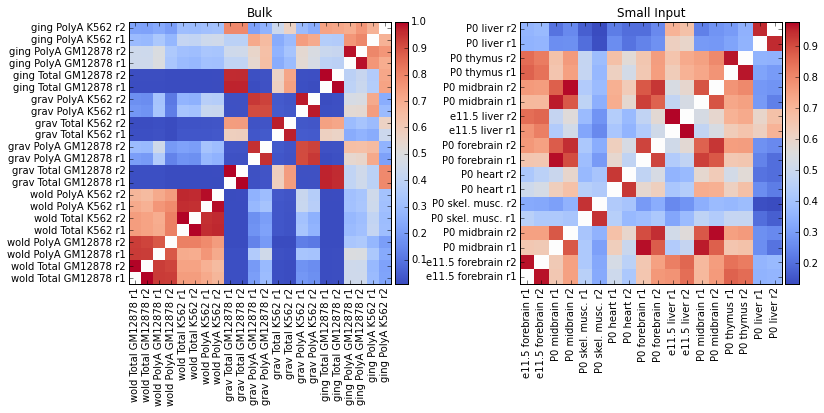

In [59]:
plot_correlations(bulk_scores, bulk_labels, low_scores, low_labels,
                  'Naïve Pearson')

## Naive Spearman Comparison

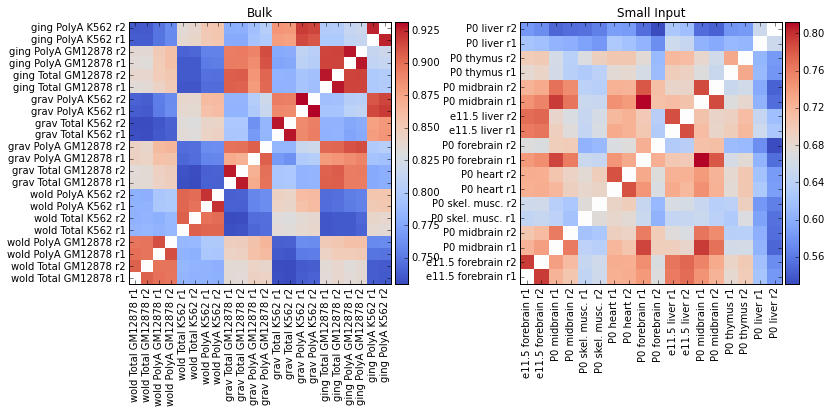

In [67]:
plot_correlations(bulk_scores, bulk_labels, low_scores, low_labels, 
                  'Naïve Spearman')

# Rafa's Comparisons

Rafa's scoring metrics use two filters. Drop all the zeros and then drop everything whose average log2 is < 0.

## Rafa Pearson Comparison

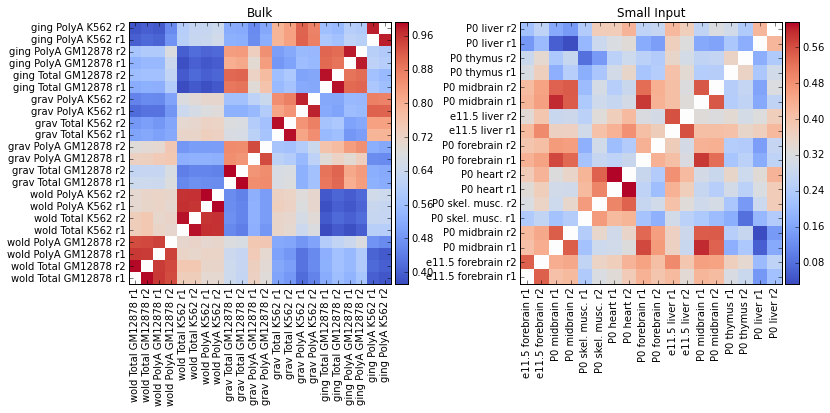

In [60]:
plot_correlations(bulk_scores, bulk_labels, low_scores, low_labels, 
                  'Rafa Pearson')

## Rafa Spearman Comparison

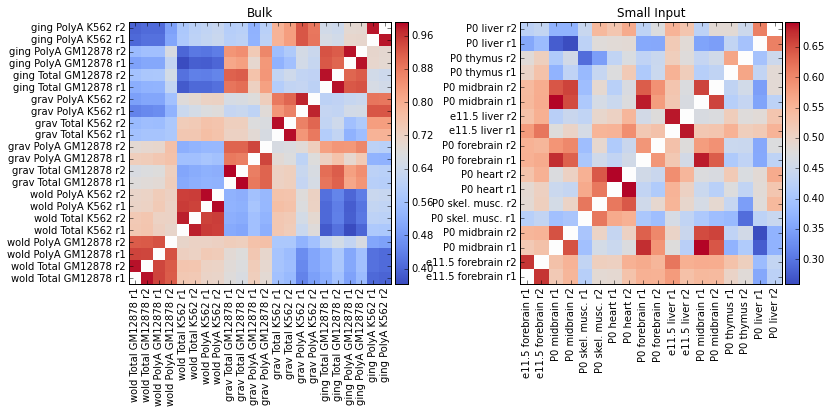

In [61]:
plot_correlations(bulk_scores, bulk_labels, low_scores, low_labels, 
                  'Rafa Spearman')

# Rafa MAD Comparison

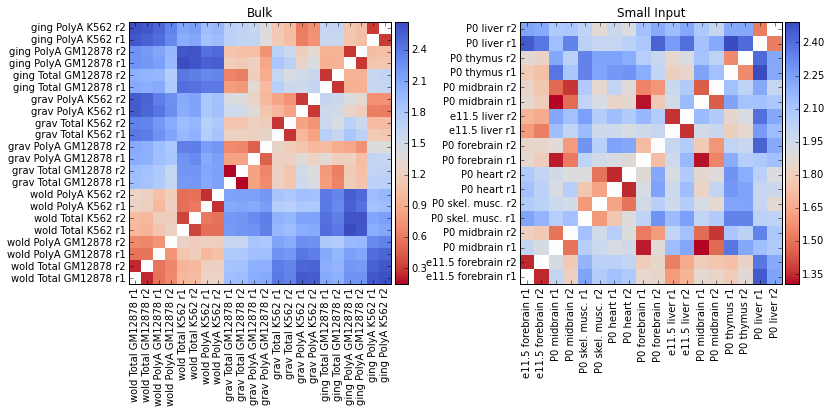

In [74]:
plot_mad(bulk_scores, bulk_labels, low_scores, low_labels, 
         'MAD')

## Rafa SD Comparison

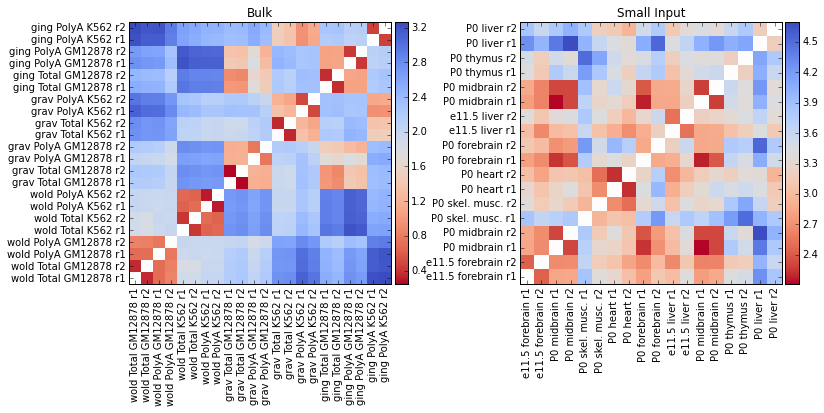

In [75]:
plot_mad(bulk_scores, bulk_labels, low_scores, low_labels, 'SD')

# Only Small Input Correlations

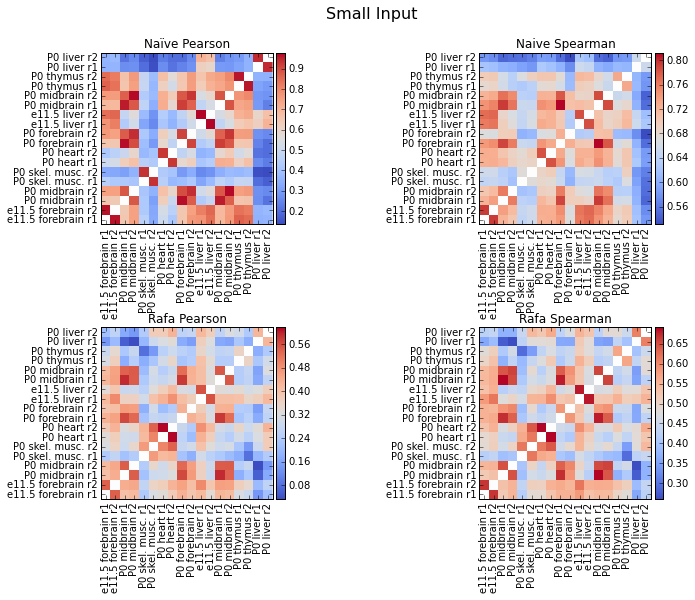

In [70]:
fig, ax = pyplot.subplots(2, 2, figsize=(12,8))
fig.suptitle('Small Input', fontsize=16)
pyplot.subplots_adjust(wspace=.3, hspace=.6)


cax = heatmap(ax[0][0], low_scores['Naïve Pearson'][low_scores['Naïve Pearson'] < 1.0],
              title='Naïve Pearson', labels=low_labels)
cax = heatmap(ax[0][1], low_scores['Naïve Spearman'][low_scores['Naïve Spearman'] < 1.0], 
              title='Naive Spearman', labels=low_labels)

cax = heatmap(ax[1][0], low_scores['Rafa Pearson'][low_scores['Rafa Pearson'] < 1.0], 
              title='Rafa Pearson', labels=low_labels)
cax = heatmap(ax[1][1], low_scores['Rafa Spearman'][low_scores['Rafa Spearman'] < 1.0], 
              title='Rafa Spearman', labels=low_labels)

fig.savefig('/tmp/low_corr.png')
fig.savefig('/tmp/small_corr.svg')


## Small Input MAD/SD

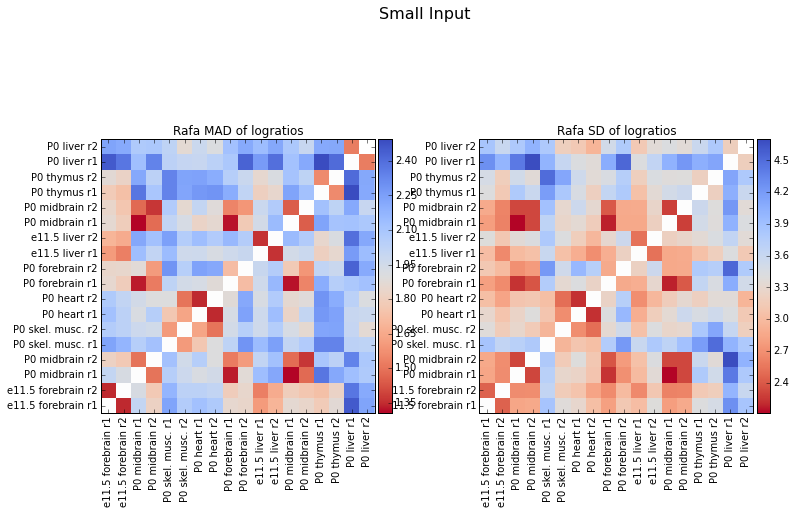

In [76]:
fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
fig.suptitle('Small Input', fontsize=16)
pyplot.subplots_adjust(wspace=.3, hspace=.6)
#'Rafa MAD of logratios', 'Rafa SD of logratios'
cax = heatmap(ax[0], low_scores['MAD'][low_scores['MAD'] > 0.0],
              title='Rafa MAD of logratios', labels=low_labels, cmap="coolwarm_r")
cax = heatmap(ax[1], low_scores['SD'][low_scores['SD'] > 0.0], 
              title='Rafa SD of logratios', labels=low_labels, cmap="coolwarm_r")

fig.savefig('/tmp/small_madsd.png')
fig.savefig('/tmp/small_madsd.svg')


# Fractions Passed Filters

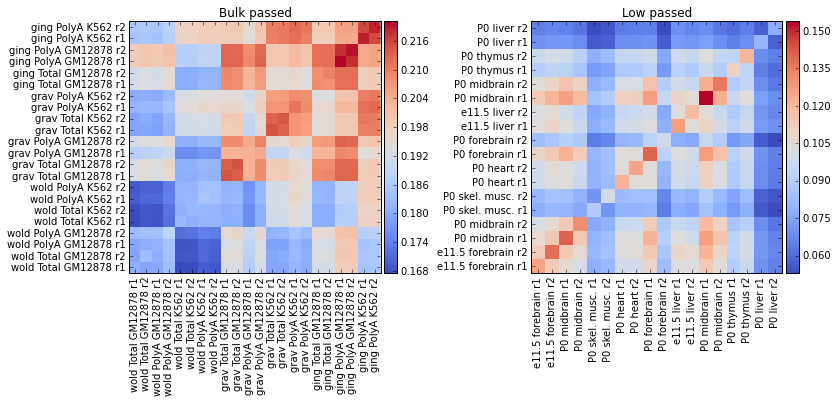

In [83]:
fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
pyplot.subplots_adjust(wspace=.5, hspace=.3)
#'Rafa MAD of logratios', 'Rafa SD of logratios'
cax = heatmap(ax[0], bulk_scores['passed filter'] / bulk_scores['total rows'],
              title='Bulk passed', labels=bulk_labels, )
cax = heatmap(ax[1], low_scores['passed filter'] / low_scores['total rows'], 
              title='Low passed', labels=low_labels)

fig.savefig('/tmp/fraction.png')
fig.savefig('/tmp/fraction.svg')

In [85]:
low_scores['passed filter']

,ENCLB917PKP,ENCLB026BHP,ENCLB719BQO,ENCLB669AEL,ENCLB304LFK,ENCLB096HAH,ENCLB652HKH,ENCLB348BMH,ENCLB766UOB,ENCLB181TCJ,ENCLB449LBZ,ENCLB905LVV,ENCLB238LIR,ENCLB765HDK,ENCLB005HHX,ENCLB185MNU,ENCLB356IIP,ENCLB791CRT
ENCLB917PKP,8790,7888,7469,7020,5423,5681,6930,6945,7545,5808,7256,7103,7922,7278,6254,6743,4867,4549
ENCLB026BHP,7888,9639,7957,7427,5647,5949,7198,7308,7974,6052,7613,7392,8415,7638,6505,7004,4990,4665
ENCLB719BQO,7469,7957,9824,7945,5575,5878,7212,7213,8480,6336,7228,6898,8840,8104,6432,6894,5008,4593
ENCLB669AEL,7020,7427,7945,9138,5315,5557,6760,6799,7861,6109,6756,6498,8296,7660,6003,6355,4782,4404
ENCLB304LFK,5423,5647,5575,5315,6213,4933,5537,5546,5630,4502,5421,5298,5922,5480,5021,5486,3926,3716
ENCLB096HAH,5681,5949,5878,5557,4933,6877,5772,5888,5882,4658,5722,5586,6229,5709,5238,5785,4035,3863
ENCLB652HKH,6930,7198,7212,6760,5537,5772,8457,7291,7266,5611,6903,6631,7691,7062,6136,6620,4780,4472
ENCLB348BMH,6945,7308,7213,6799,5546,5888,7291,8740,7290,5674,7002,6772,7732,7086,6217,6699,4796,4525
ENCLB766UOB,7545,7974,8480,7861,5630,5882,7266,7290,9776,6457,7193,6938,8864,8112,6386,6866,4924,4568
ENCLB181TCJ,5808,6052,6336,6109,4502,4658,5611,5674,6457,6848,5494,5361,6627,6243,5019,5301,3984,3694


# Future Work

* Figure out how how to cluster on correlation scores to get related things next to each other.
* DONE Heat map of how much data is left after filtering.
* compute synthetic merged single cell data to compare against bulk data.
* given a related tissue, show similar correlations plots between different amounts of input material.
  * also compare rank correlation of genes detected between 13 pg and 10 ng samples.
  * venn diagrams of 13pg as subset of 10ng
  * fraction of reads mapped. how do the reads mapped change as we go from 1, 10, 50, 1000 cells...
  * Brian needs to find wet bench QC e.g. yield, bioanalyzer distribution
* show plots with autoscale on and the self-vs-self column removed.

* DONE invert colors for MAD. (apparently many pyplot colormaps have a _r variant)

